# Plot

In [1]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm
import itertools

delphesDir = os.path.abspath("../MG5/Delphes")
os.environ['ROOT_INCLUDE_PATH'] = os.path.join(delphesDir,"external")

import ROOT

ROOT.gSystem.Load(os.path.join(delphesDir,"libDelphes.so"))

ROOT.gInterpreter.Declare('#include "classes/SortableObject.h"')
ROOT.gInterpreter.Declare('#include "classes/DelphesClasses.h"')
ROOT.gInterpreter.Declare('#include "external/ExRootAnalysis/ExRootTreeReader.h"')

import sys
sys.path.append('../recastCode')
from helper import eventReader

plt.style.use('fivethirtyeight') #Set style
plt.rcParams.update({'figure.figsize' : (15,10)})  #Set general plotting options
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution


#Define plotting style:
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.colormaps['RdYlBu']

colors = sns.color_palette('Paired')

Welcome to JupyROOT 6.30/06


### Load Recast Data

In [2]:
# inputFile = '../pp2ZH/Events/run_02/ctau_1000mm_delphes_events.root'
# ctau = float(inputFile.split('ctau_')[1].split('mm')[0])
inputFile = '../HZcms_1000mm.root'
ctau = 1000.0


In [3]:
methods = ['smearVtx']
Rvals = [None]
nevts = -1
allResults = []
for method,R in itertools.product(methods,Rvals):
    print('Getting results for method = %s and Rmax = %s' %(method,R))
    f = ROOT.TFile(inputFile,'read')
    allResults.append(eventReader(f,nevts,method,R))
    f.Close()

            

Getting results for method = smearVtx and Rmax = None


/home/lessa/exoHiggsEJ/plotting/../recastCode/helper.py:168: RuntimeWarning: divide by zero encountered in log10
  ltheta = np.log10(theta)


### Plot Distributions

In [4]:
cmsIP2D = np.genfromtxt('../CMS_data/HEPData-ins1954276-v1-Figure_002-a.csv',skip_footer=0,skip_header=148,delimiter=',')
bins = cmsIP2D[:-1,0]-np.diff(cmsIP2D[:,0])/2

In [5]:
title = r'$c\tau_s = %1.0f$ mm' %(ctau)
colors = sns.color_palette('Paired')

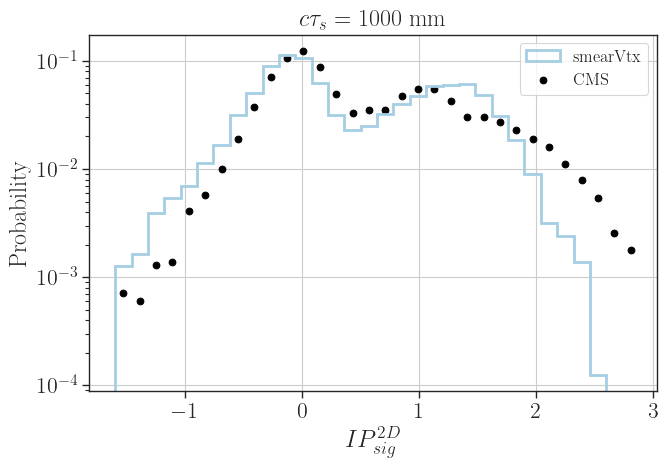

In [6]:
fig = plt.figure(figsize=(7,5))
for i,resDict in enumerate(allResults):
    IP2D = resDict['IP2D']
    label = '%s' %(resDict['method'])
    if resDict['Rmax'] is not None:
        label += r' ($R < %1.0f$ mm)' %resDict['Rmax']
    h1,_,_ = plt.hist(IP2D,histtype='step',linewidth=2,bins=bins,density=False,weights=[1.0/len(IP2D)]*len(IP2D),label=label,color=colors[i])
plt.scatter(cmsIP2D[:,0],cmsIP2D[:,1],label='CMS',color='black')
# np.savetxt('./ip2d_1mm.csv',list(zip(bins,h1)),header='bin,bin_content',delimiter=',',fmt='%1.4e')
plt.legend(fontsize=12)
plt.yscale('log')
# plt.ylim(1e-2,10)
# plt.xlim(-1.5,3.0)
plt.grid()
plt.xlabel(r'$IP_{sig}^{2D}$',fontsize=18)
plt.ylabel('Probability')
plt.title(title)

plt.tight_layout()
plt.savefig('IP2D_1000mm.png')
plt.show()

## Check Event

In [54]:
ievt = 61
np.random.seed(0)
f = ROOT.TFile(inputFile,'read')
tree = f.Get("Delphes")
tree.GetEntry(ievt)   
jets = tree.Jet
tracks = tree.Track    
from helper import getJetTracks,getD0,getSigmaD0,getAlpha,getIP2D 
d0 = []
sigmaD0 = []
good_jets = []
print('----- Event %i ------' %ievt)
print('%i jets' %len(jets))
for ij,j in enumerate(jets):
    print('\njet %i: PT = %1.3f, jet Eta = %1.3f' %(ij+1,j.PT,j.Eta))
    if j.PT < 35.0:
        continue
    if abs(j.Eta) > 2.4:
        continue
    good_jets.append(j)
    jet_tracks = getJetTracks(j,tracks)
    print('%i tracks matched' %len(jet_tracks))
    if len(jet_tracks) == 0:
        continue
    for it,track in enumerate(jet_tracks):
        print(' track %i: PT = %1.3f, ID = %i, D0 (true) = %1.2e mm' %(it+1,track.PT,track.PID, track.D0))
        tD0 = getD0(track,smear=True,method=method)
        tSD0 = getSigmaD0(track,method=method)
        print('      after smearing: D0 = %1.2e, sigmaD0 = %1.2e' %(tD0,tSD0) )
        d0.append(tD0)
        sigmaD0.append(tSD0)
    ip2D = getIP2D(jet_tracks,smear=True,method='smearVtx')
    print('IP2D = %1.3f' %ip2D)

f.Close()

----- Event 61 ------
3 jets

jet 1: PT = 70.139, jet Eta = 0.070
2 tracks matched
 track 1: PT = 1.516, ID = 211, D0 (true) = 0.00e+00 mm
      after smearing: D0 = 9.17e-03, sigmaD0 = 3.39e-02
 track 2: PT = 67.830, ID = 11, D0 (true) = 0.00e+00 mm
      after smearing: D0 = 4.46e-02, sigmaD0 = 3.39e-02
IP2D = -0.782

jet 2: PT = 32.484, jet Eta = 0.825

jet 3: PT = 31.681, jet Eta = 0.486
